### 3-layer DCT-III StNN - Generator matrix encoded data

In [235]:
%reset -f
import gc
gc.collect()

0

In [236]:
import numpy as np
import tensorflow as tf
from scipy.fftpack import dct
import math

np.random.seed(42)

In [237]:
# (x, y, z, w) --> (1, 2, 3, 4)
global z0
global w0

w0 = 4
z0 = 3

n = 27
q = 7

num_samples = 1000

In [238]:
def next_power_of_two(x):
    return 2 ** math.ceil(math.log2(x))

n_padded = next_power_of_two(n)

x_original = np.random.randint(0, q, size=(num_samples, n))

padding = n_padded - n
dataset = np.pad(x_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

print(f"Original n: {n}, Padded to: {n_padded}")

Original n: 27, Padded to: 32


In [239]:
x_original.shape

(1000, 27)

In [240]:
dataset.shape

(1000, 32)

Encode using generator matrix
$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [241]:
def padded_generator_matrix(N, w0, z0):
    n = np.arange(N)
    k = n.reshape((N, 1))
    zeta = np.exp(-2j * np.pi / N)
    M_tilde = ((w0 / z0) ** n) * (zeta ** (k * n))
    return M_tilde

In [242]:
M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(32, 32)


In [243]:
encoded_dataset = np.array([np.dot(M_tilde, x) for x in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
encoded_dataset.shape

(1000, 32)

In [244]:
print(f"x_original[0]:", x_original[0])
print(f"\nAfter encoding:\n", encoded_dataset[0])

x_original[0]: [6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3]

After encoding:
 [18563.60052945    +0.j         -3175.07412411+14542.65392496j
 -9480.13851167 -1549.89213738j  -850.18419129 -5788.51248279j
  2813.63372348 -2457.36436449j  3312.0476391   +337.88077825j
  1059.2907911  +3489.68169028j -2366.82367016  +909.74502726j
  -210.29906943  +357.85181443j -3878.07651347  +373.95548592j
   -49.25036994 -6370.32567308j  6901.71964373 -1088.5938127j
  2896.76301761 +7252.43377368j -6714.83312544 +4427.90575271j
 -5496.28870703 -5330.43278044j  2828.24226801 -6162.17891893j
  6446.94186958    -0.j          2828.24226801 +6162.17891893j
 -5496.28870703 +5330.43278044j -6714.83312544 -4427.90575271j
  2896.76301761 -7252.43377368j  6901.71964373 +1088.5938127j
   -49.25036994 +6370.32567308j -3878.07651347  -373.95548592j
  -210.29906943  -357.85181443j -2366.82367016  -909.74502726j
  1059.2907911  -3489.68169028j  3312.0476391   -337.88077825j
  2813.63372348 +2457.36436449j

In [ ]:
N = encoded_dataset.shape[1]

k = np.arange(N)
shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))

dct2_dataset = np.array([np.real(alpha_k * shift * y) for y in encoded_dataset])
dct2_dataset[np.abs(dct2_dataset) < 1e-10] = 0
dct2_dataset = np.round(dct2_dataset, decimals=10) # Round for numerical stability

In [246]:
"""
The part below is for testing purposes only
"""

from scipy.fftpack import dct

dct3_dataset = np.array([dct(x, type=3, norm='ortho') for x in dct2_dataset])

X_perm = np.hstack((dct3_dataset[:, ::2], dct3_dataset[:, 1::2][:, ::-1]))

D_hat_n = np.array([(z0 / w0) ** k for k in range(N)])
decoded_dataset = X_perm * D_hat_n

# Print verification (for one sample)
sample_idx = 78
print("Original x:", dataset[sample_idx])
print("\nEncoded y:", encoded_dataset[sample_idx])
print("\nDCT Coefficients:", np.round(dct2_dataset[sample_idx], 4))
print("\nReconstructed Signal:", np.round(dct3_dataset[sample_idx], 4))
print("\nAfter Permutation:", np.round(X_perm[sample_idx], 4))
print("\nAfter Scaling:", np.round(decoded_dataset[sample_idx], 4))

Original x: [4 3 6 4 2 0 5 6 6 2 2 1 6 1 1 5 1 4 3 0 2 4 0 6 6 6 4 0 0 0 0 0]

Encoded y: [ 29916.11588021    +0.j            328.95686704+26422.4846445j
 -21936.20111033 +3988.95593508j  -7301.38988823-17810.36382931j
  13577.84642585 -8953.74117052j   9354.9421295  +8727.48732799j
  -4221.49645678 +8798.15590637j  -7861.90722461  -861.73832776j
   -779.76795929 -5322.56486315j   2168.22506293 -1740.90057156j
   1615.33333537 -1441.8771791j    5127.91361716 +2018.69510167j
  -2943.81135295 +6208.60576073j  -5262.87924206 -2070.18847016j
    798.8487054  -4460.7613612j    2679.94226354  +633.97975698j
   -477.22622529    -0.j           2679.94226354  -633.97975698j
    798.8487054  +4460.7613612j   -5262.87924206 +2070.18847016j
  -2943.81135295 -6208.60576073j   5127.91361716 -2018.69510167j
   1615.33333537 +1441.8771791j    2168.22506293 +1740.90057156j
   -779.76795929 +5322.56486315j  -7861.90722461  +861.73832776j
  -4221.49645678 -8798.15590637j   9354.9421295  -8727.48732799j
 

In [247]:
y = dataset.astype(np.float32)
y_normalized = y / (q - 1)  # Scale to [0, 1]

# labels = y
labels = y_normalized

In [248]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dct2_dataset, labels, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 32) (800, 32)
(200, 32) (200, 32)


In [249]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

DCT-3 imposed 1 StNN (one custom layer)

In [250]:
class FirstLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(FirstLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        init_diag = tf.ones(self.n1, dtype=tf.float32)
        init_diag = tf.tensor_scatter_nd_update(init_diag, [[0]], [tf.sqrt(2.0)])

        self.B_1 = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_diag),
                trainable=self.trainable,
                name='B_1'
            )
        self.B_2 = self.add_weight(
                shape=(self.n1,),
                initializer='ones',
                trainable=self.trainable,
                name='B_2'
            )
        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, x):
        even = x[:, ::2]
        odd = x[:, 1::2]

        d1 = tf.multiply(odd, self.B_1) # diagonal
        d2 = tf.multiply(tf.concat([tf.zeros_like(odd[:, :1]), odd[:, :-1]], axis=1), self.B_2) # off-diagonal
        B_n = tf.add(d1, d2)

        u = tf.concat([even, B_n], axis=1)

        return u + self.bias

In [ ]:
class DCTIII(tf.keras.layers.Layer):
    def __init__(self, n, trainable=True, **kwargs):
        super(DCTIII, self).__init__(**kwargs)
        self.n = n
        self.n1 = n // 2 if n > 2 else 1
        self.trainable = trainable

        if n == 2:
            # Base case: trainable 2x2 matrix
            self.C_2 = self.add_weight(
                shape=(2, 2),
                initializer=tf.keras.initializers.Constant((1 / np.sqrt(2)) * np.array([[1., 1.], [1., -1.]])),
                trainable=self.trainable,
                name='C_2'
            )
        else:
            init_diag = tf.ones(self.n1, dtype=tf.float32)
            init_diag = tf.tensor_scatter_nd_update(init_diag, [[0]], [tf.sqrt(2.0)])

            # Weights for B^T_{n/2}
            self.B_1 = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_diag),
                trainable=self.trainable,
                name='B_1'
            )
            self.B_2 = self.add_weight(
                shape=(self.n1,),
                initializer='ones',
                trainable=self.trainable,
                name='B_2'
            )

            k = tf.cast(tf.range(1, self.n1 + 1), tf.float32)
            pi = tf.constant(np.pi, dtype=tf.float32)
            init_W_c = 1 / (2 * tf.cos((2 * k - 1) * (pi / (2 * self.n))))

            # Weight for W_c
            self.w_c = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_W_c),
                trainable=self.trainable,
                name='W_c'
            )

            # Recursive DCTIII for n/2
            self.dctiii_layer1 = DCTIII(self.n1,trainable=self.trainable)
            self.dctiii_layer2 = DCTIII(self.n1,trainable=self.trainable)

    def call(self, x):
        if self.n == 2:
            y = tf.matmul(self.C_2, x, transpose_b=True)
            return tf.transpose(y)
        else:
            # Permutation
            even = x[:, ::2]
            odd = x[:, 1::2]

            # B^T
            d1 = tf.multiply(odd, self.B_1)
            d2 = tf.multiply(tf.concat([tf.zeros_like(odd[:, :1]), odd[:, :-1]], axis=1), self.B_2)
            B_n = tf.add(d1, d2)
            u = tf.concat([even, B_n], axis=1)

            # Recursive DCTIII
            z1 = self.dctiii_layer1(u[:, :self.n1])
            z2 = self.dctiii_layer2(u[:, self.n1:])
            recurs_out = tf.concat([z1, z2], axis=1)

            # W_c
            W_n = tf.multiply(recurs_out[:, self.n1:], self.w_c)
            v = tf.concat([recurs_out[:, :self.n1], W_n], axis=1)

            # H_n
            out1 = v[:, :self.n1]
            out2 = v[:, self.n1:]
            y = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat(
                [(out1 + out2), tf.reverse((out1 - out2), axis=[1])],
                axis=1
            )

            return y

In [ ]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

        # Recursive DCTIII for n/2
        self.dctiii1 = DCTIII(self.n1, trainable=self.trainable)
        self.dctiii2 = DCTIII(self.n1,trainable=self.trainable)

    def call(self, x):
        z1 = self.dctiii1(x[:, :self.n1])
        z2 = self.dctiii2(x[:, self.n1:])
        out = tf.concat([z1, z2], axis=1)
        return out + self.bias

In [ ]:
class ThirdLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(ThirdLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        k = tf.cast(tf.range(1, self.n1 + 1), tf.float32)
        pi = tf.constant(np.pi, dtype=tf.float32)
        init_W_c = 1 / (2 * tf.cos((2 * k - 1) * (pi / (2 * self.n))))

        self.w_c = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_W_c),
                trainable=self.trainable,
                name='W_c'
            )

        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, x):
        input1 = x[:, :self.n1]
        input2 = x[:, self.n1:]

        # W_{N/2}
        W_n = tf.multiply(input2, self.w_c)
        v = tf.concat([input1, W_n], axis=1)

        # H_n^T
        out1 = v[:, :self.n1]
        out2 = v[:, self.n1:]

        y = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat([(out1 + out2), tf.reverse((out1 - out2), axis=[1])], axis=1)

        return y + self.bias

In [254]:
class DiagonalLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, kernel_initializer='he_normal', bias_initializer='zeros', **kwargs):
        super(DiagonalLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.trainable = trainable

    def build(self, input_shape):
        self.diag = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.get(self.kernel_initializer),
            trainable=self.trainable,
            name='diag'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.get(self.bias_initializer),
            trainable=self.trainable,
            name='bias'
        )

    def call(self, inputs):
        scaled = tf.multiply(inputs, self.diag)
        return scaled + self.bias

In [ ]:
class ScalingLayer(tf.keras.layers.Layer):
    def __init__(self, units, initial_scale=1.0, trainable=True, kernel_initializer='he_normal', bias_initializer='zeros', **kwargs):
        super(ScalingLayer, self).__init__(**kwargs)
        self.units = units
        self.initial_scale = initial_scale
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer

    def build(self, input_shape):

      self.log_scale = self.add_weight(
          shape=(),
          initializer=tf.keras.initializers.Constant(self.initial_scale),
          trainable=True,
          name="log_scale",
      )
      self.diag = self.add_weight(
          shape=(self.units,),
          initializer=tf.keras.initializers.get(self.kernel_initializer),
          regularizer=tf.keras.regularizers.l2(1e-4),
          trainable=True,
          name='diag'
      )
      self.bias = self.add_weight(
          shape=(self.units,),
          initializer=tf.keras.initializers.get(self.bias_initializer),
          trainable=True,
          name='bias'
        )

      super().build(input_shape)

    def call(self, inputs):
      perm = tf.concat([inputs[:, ::2], inputs[:, 1::2][:, ::-1]], axis=-1)

      dim = tf.shape(perm)[1]

      D_hat_n = tf.exp(self.log_scale * tf.cast(tf.range(dim), tf.float32))

      scaled = perm * D_hat_n * self.diag

      return scaled + self.bias

Model

In [ ]:
def custom_accuracy(y_true, y_pred):
    y_true_int = tf.cast(y_true*(q-1), tf.int32)
    y_pred_int = tf.cast(tf.round(y_pred*(q-1)), tf.int32)
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32)
    return tf.reduce_mean(correct)

def custom_accuracy_without_padding(y_true, y_pred):
    y_true_int = tf.cast(y_true * (q - 1), tf.int32)
    y_pred_int = tf.cast(tf.round(y_pred * (q - 1)), tf.int32)
    mask = tf.concat(
        [tf.ones((tf.shape(y_true)[0], n), dtype=tf.float32),
         tf.zeros((tf.shape(y_true)[0], n_padded - n), dtype=tf.float32)],
        axis=1
    )
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32) * mask
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

def custom_mse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    loss = tf.reduce_mean(tf.square(tf.cast(y_true - y_pred, tf.float32)))
    return loss

In [ ]:
from tensorflow.keras.layers import InputLayer, LeakyReLU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initial_log_scale = np.log(z0 / w0)
initial_scale = (z0 / w0)

input_shape = (n_padded,)
model = Sequential([
    InputLayer(shape=input_shape),
    FirstLayer(units=n_padded, trainable=True, name="first_layer"),
    # LeakyReLU(negative_slope=0.1),
    SecondLayer(units=n_padded, trainable=True, name="second_layer"),
    # LeakyReLU(negative_slope=0.1),
    ThirdLayer(units=n_padded, trainable=True, name="third_layer"),
    LeakyReLU(negative_slope=0.1),
    ScalingLayer(units=n_padded, initial_scale=initial_log_scale, kernel_initializer='ones', bias_initializer='zeros', name="scaling_layer"),
    LeakyReLU(negative_slope=0.1),
    DiagonalLayer(units=n_padded, trainable=False, kernel_initializer='ones', bias_initializer='zeros', name="output_layer"),
    Activation('linear')
])

# notes:
# 1. adding the diagonal layers in the middle worsens results
# 2. residual connections does not work
# 3. removing bias in hidden layers worsens performance
# 4. removing "LeakyReLU" activation in between layers improved performance


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=custom_mse,
    metrics=[custom_mse, custom_accuracy_without_padding]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ first_layer (FirstLayer)             │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (SecondLayer)           │ (None, 32)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_layer (ThirdLayer)             │ (None, 32)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scaling_layer (ScalingLayer)         │ (None, 32)                  │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (DiagonalLayer)         │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 64 (256.00 B)

Training

In [258]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - custom_accuracy_without_padding: 0.1415 - custom_mse: 0.2881 - loss: 0.2913 - val_custom_accuracy_without_padding: 0.1480 - val_custom_mse: 0.2402 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_accuracy_without_padding: 0.1401 - custom_mse: 0.2396 - loss: 0.2427 - val_custom_accuracy_without_padding: 0.1496 - val_custom_mse: 0.2068 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_accuracy_without_padding: 0.1393 - custom_mse: 0.2071 - loss: 0.2103 - val_custom_accuracy_without_padding: 0.1533 - val_custom_mse: 0.1821 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_accuracy_without_padding: 0.1504 - custom_mse: 0.1854 - loss: 0.1886 - val_custom_accuracy_without_padding: 0.1493 - val_custom_mse: 0.1605 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 5/500
25/25 ━━━━━━

In [259]:
# Evaluate the model on the test set
eval_results = model.evaluate(X_test, y_test)
print(f"Test results - Loss: {eval_results[0]}, MSE: {eval_results[1]}, Accuracy: {eval_results[2]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_accuracy_without_padding: 0.7084 - custom_mse: 0.0265 - loss: 0.0278 
Test results - Loss: 0.028354652225971222, MSE: 0.026951540261507034, Accuracy: 0.7065146565437317


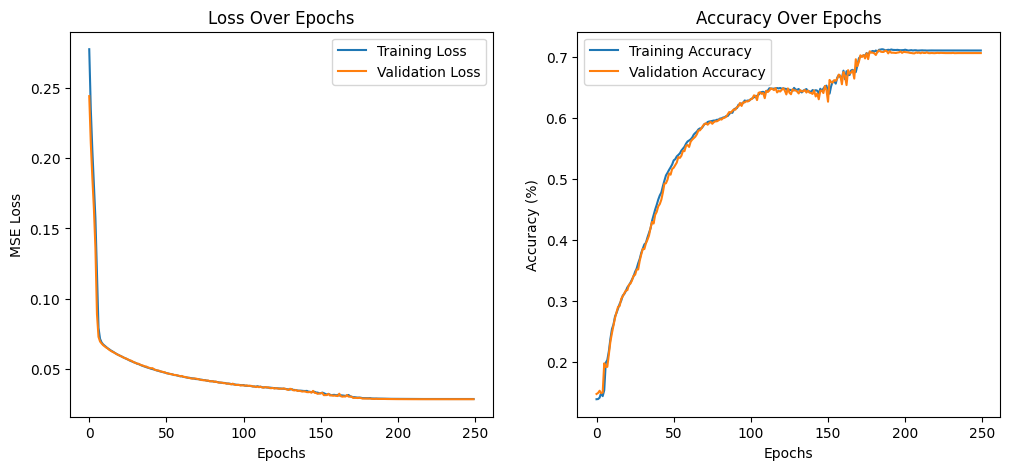

In [260]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy_without_padding'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy_without_padding'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [261]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step
R² Score: 0.6015


In [262]:
y_pred = model.predict(X_test)
y_test_rescaled = y_test * (q - 1)
y_pred_rescaled = y_pred * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Predicted:    {np.round(y_pred_rescaled[i]).astype(int)}")
    print(f"  Ground Truth: {np.round(y_test_rescaled[i]).astype(int)}")
    print("-" * 40)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [3 3 3 3 3 3 3 3 4 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
  Ground Truth: [5 6 5 1 3 4 1 1 6 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
----------------------------------------
Sample 2:
  Predicted:    [3 3 3 3 3 3 3 3 3 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
  Ground Truth: [1 4 1 3 3 3 0 5 5 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
----------------------------------------
Sample 3:
  Predicted:    [3 3 3 3 3 3 3 3 3 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
  Ground Truth: [2 6 0 2 2 1 3 4 2 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
----------------------------------------


Test on unseen samples

In [263]:
num_unseen_samples = 20
x_unseen_original = np.random.randint(0, q, size=(num_unseen_samples, n))
x_unseen_original_padded = np.pad(x_unseen_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

encoded_dataset_unseen = np.array([np.dot(M_tilde, x) for x in x_unseen_original_padded])
encoded_dataset_unseen[np.abs(encoded_dataset_unseen) < 1e-10] = 0
encoded_dataset_unseen = np.round(encoded_dataset_unseen, decimals=10)

# add some noise to simulate channel distortion
noise_ratio = 0.01
real_parts = np.real(encoded_dataset_unseen)
imag_parts = np.imag(encoded_dataset_unseen)
noise_std_real = np.abs(real_parts) * noise_ratio
noise_std_imag = np.abs(imag_parts) * noise_ratio
noise_real = np.random.normal(0, noise_std_real, size=encoded_dataset_unseen.shape)
noise_imag = np.random.normal(0, noise_std_imag, size=encoded_dataset_unseen.shape)
noise = noise_real + 1j * noise_imag

encoded_noisy = encoded_dataset_unseen + noise

print(encoded_dataset_unseen[0])
print("\n")
print(encoded_noisy[0])

[ 17700.17533602    +0.j            958.67427771+14545.05859731j
 -11067.68026502 +4750.16621573j  -7541.94219873 -8050.90562821j
   4801.06762678 -8458.12148009j   8081.44036169 +1412.87970794j
    909.73843657 +6296.7835732j   -2846.8320572  +2775.87690291j
  -3741.2973968   +487.64736489j  -3997.29300812 -2951.21922264j
   1247.21351285 -6986.82292053j   9126.05640729 -1748.64789028j
   4268.0738087 +10289.38728272j  -8635.34104673 +6950.27874978j
 -10343.34361125 -6073.81272702j   3258.84443464-12644.40361606j
  13345.0660992     -0.j           3258.84443464+12644.40361606j
 -10343.34361125 +6073.81272702j  -8635.34104673 -6950.27874978j
   4268.0738087 -10289.38728272j   9126.05640729 +1748.64789028j
   1247.21351285 +6986.82292053j  -3997.29300812 +2951.21922264j
  -3741.2973968   -487.64736489j  -2846.8320572  -2775.87690291j
    909.73843657 -6296.7835732j    8081.44036169 -1412.87970794j
   4801.06762678 +8458.12148009j  -7541.94219873 +8050.90562821j
 -11067.68026502 -4750.16

In [264]:
# projection to get real-valued DCT-2 like input
N = encoded_dataset_unseen.shape[1]

k = np.arange(N)
shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))

x_unseen_dct2 = np.array([np.real(alpha_k * shift * y) for y in encoded_dataset_unseen])
x_unseen_dct2[np.abs(x_unseen_dct2) < 1e-10] = 0
x_unseen_dct2 = np.round(x_unseen_dct2, decimals=10) # for numerical stability

x_unseen_dct2_noisy = np.array([np.real(alpha_k * shift * y) for y in encoded_noisy])
x_unseen_dct2_noisy[np.abs(x_unseen_dct2_noisy) < 1e-10] = 0
x_unseen_dct2_noisy = np.round(x_unseen_dct2_noisy, decimals=10) # for numerical stability

print(x_unseen_dct2[0])
print("\n")
print(x_unseen_dct2_noisy[0])

[ 3128.97850207   417.80292772 -2637.19716272 -2160.40631628
   764.67970384  2045.63787182   674.60629805  -436.31326629
  -817.47338064 -1218.82972282  -548.40535184  1732.1737495
  2316.31274132  -698.92368709 -2962.17468438 -1519.20450647
  2359.09668353  2889.34781282  -466.65674826 -2681.64572333
 -1546.02452359  1547.89899174  1687.44002098   239.70189834
  -470.5649872   -893.1698145  -1440.39076453   148.27308981
  2308.06071922  1714.28349356 -1453.02880918 -3620.12463   ]


[ 3126.38534375   419.79929625 -2586.73955992 -2190.34267946
   769.74928953  2047.58320081   671.72685429  -422.21935348
  -815.21639446 -1212.60023073  -542.22461636  1724.33756215
  2320.60093533  -686.75620414 -2969.19370517 -1531.16340956
  2388.34797036  2905.78597183  -500.81339168 -2680.27954514
 -1532.20981845  1545.78402376  1685.16535565   232.36448675
  -468.02567276  -898.13201027 -1418.18678094   156.22354753
  2315.0969486   1754.57126786 -1473.48467009 -3567.4538734 ]


In [265]:
# classical algorithm
from scipy.fft import ifft

def lrc(y, n, q, r, w0, z0):
    if n >= 2:
        z1 = ifft(y, n)

        D_hat_n = np.diag([(z0 / w0) ** k for k in range(n)])
        z2 = np.dot(D_hat_n, z1)

        J_rxn = np.hstack([np.eye(r), np.zeros((r, n - r))])
        z3 = np.dot(J_rxn, z2)

        z4 = np.abs(z3)

        # z5 = np.ceil(z4)
        z5 = np.round(z4)

        x_tilde = np.mod(z5, q)

        return x_tilde

    return y

In [266]:
############## just to compare with classical dct3 ##############

classical_dct3_pred = np.array([dct(x, type=3, norm='ortho') for x in x_unseen_dct2_noisy])
after_perm = np.hstack((classical_dct3_pred[:, ::2], classical_dct3_pred[:, 1::2][:, ::-1]))
D_hat_n = np.array([(z0 / w0) ** k for k in range(N)])
scaled_dct3_pred = after_perm * D_hat_n

mse_classical_dct3 = custom_mse(x_unseen_original_padded, scaled_dct3_pred)
acc_classical_dct3 = custom_accuracy_without_padding(x_unseen_original_padded, scaled_dct3_pred)

############## classical algorithm for recovery (here we assume the classical algorithm can also be used for global recovery. just to compare) ##############

classical_pred = np.array([lrc(y=x, n=n_padded, q=q, r=n_padded, w0=w0, z0=z0) for x in encoded_noisy])
mse_classical = custom_mse(x_unseen_original_padded, classical_pred)
acc_classical = custom_accuracy_without_padding(x_unseen_original_padded, classical_pred)

############## predictions of our StNN ##############

x_unseen_original_padded_normalized = x_unseen_original_padded.astype(np.float32) / (q - 1)  # Scale to [0, 1]

x_unseen_dct2_noisy = (x_unseen_dct2_noisy - x_unseen_dct2_noisy.mean()) / x_unseen_dct2_noisy.std()
nn_pred = model.predict(x_unseen_dct2_noisy)

y_pred_final = np.mod(np.round(nn_pred * (q - 1)), q)

mse_nn = custom_mse(x_unseen_original_padded, y_pred_final)
acc_nn = custom_accuracy_without_padding(x_unseen_original_padded_normalized, nn_pred)

############## display ##############

print(f"\nClassical DCT-III:")
print(f"  MSE: {mse_classical_dct3}")
print(f"  Accuracy: {acc_classical_dct3}")

print(f"\nClassical Algorithm:")
print(f"  MSE: {mse_classical}")
print(f"  Accuracy: {acc_classical}")

print(f"\nNeural Network:")
print(f"  MSE: {mse_nn}")
print(f"  Accuracy: {acc_nn}")

num_display_samples = 3
for i in range(num_display_samples):
    print(f"\nSample {i+1}:")
    print(f"Original     : {x_unseen_original_padded[i]}")
    # print(f"DCT-III Pred : {np.round(scaled_dct3_pred[i]).astype(int)}")
    print(f"Classical Al : {np.round(classical_pred[i]).astype(int)}")
    print(f"NN Pred      : {np.mod(np.round(nn_pred[i]*(q-1)), q).astype(int)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step

Classical DCT-III:
  MSE: 15.607465744018555
  Accuracy: 0.39814814925193787

Classical Algorithm:
  MSE: 1.9171874523162842
  Accuracy: 0.6592592597007751

Neural Network:
  MSE: 3.604687452316284
  Accuracy: 0.49259260296821594

Sample 1:
Original     : [0 5 3 5 5 5 3 5 3 4 6 0 1 5 2 4 2 1 3 1 2 1 0 1 5 0 5 0 0 0 0 0]
Classical Al : [0 1 2 4 6 0 5 3 3 3 5 1 1 6 2 4 2 1 3 1 2 1 0 1 5 0 5 0 0 0 0 0]
NN Pred      : [3 3 3 3 3 3 4 3 3 3 0 0 1 0 3 5 2 1 3 1 2 1 0 1 6 0 6 0 0 0 0 0]

Sample 2:
Original     : [6 6 1 0 0 6 1 4 3 3 3 0 6 3 6 0 6 4 1 6 6 1 0 0 6 4 3 0 0 0 0 0]
Classical Al : [0 3 3 1 1 4 1 5 3 2 2 1 6 3 6 0 6 4 1 6 6 1 0 0 6 4 3 0 0 0 0 0]
NN Pred      : [3 3 3 3 3 3 3 4 2 3 2 0 6 3 6 0 0 4 1 0 0 1 0 0 0 4 3 0 0 0 0 0]

Sample 3:
Original     : [4 1 1 5 3 6 1 5 0 1 2 3 5 3 3 2 4 0 3 1 0 1 0 6 0 5 1 0 0 0 0 0]
Classical Al : [0 0 4 6 4 0 4 4 2 1 3 3 5 3 3 2 4 0 3 1 0 1 0 6 0 5 1 0 0 0 0 0]
NN Pred      : [3 3 3 3 3 3 3 3 3 2 1 3 6 3 3 3 5

Visualize and Analyse model training

(array([1.479e+03, 5.700e+01, 7.000e+00, 1.700e+01, 1.000e+01, 3.700e+01,
        2.040e+02, 2.320e+02, 4.600e+01, 6.000e+00, 3.000e+00, 4.000e+00,
        1.800e+01, 1.260e+02, 2.970e+02, 1.050e+02, 2.900e+01, 3.700e+01,
        6.300e+01, 8.500e+01, 2.470e+02, 8.860e+02, 5.640e+02, 1.460e+02,
        5.700e+01, 3.900e+01, 4.400e+01, 4.700e+01, 1.890e+02, 2.760e+02,
        4.900e+01, 8.000e+00, 3.000e+00, 2.000e+00, 1.300e+01, 9.500e+01,
        3.100e+02, 6.400e+01, 1.200e+01, 8.000e+00, 2.000e+00, 1.000e+01,
        5.000e+01, 2.510e+02, 1.070e+02, 2.300e+01, 1.600e+01, 1.200e+01,
        7.000e+00, 1.000e+00]),
 array([-1.05405517e-03,  2.22476535e-02,  4.55493629e-02,  6.88510761e-02,
         9.21527818e-02,  1.15454488e-01,  1.38756216e-01,  1.62057921e-01,
         1.85359627e-01,  2.08661333e-01,  2.31963038e-01,  2.55264759e-01,
         2.78566480e-01,  3.01868170e-01,  3.25169891e-01,  3.48471582e-01,
         3.71773303e-01,  3.95075023e-01,  4.18376714e-01,  4.41678435e-

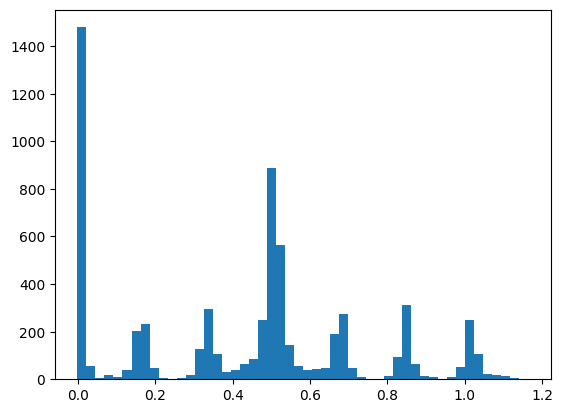

In [267]:
import matplotlib.pyplot as plt
plt.hist(y_pred.flatten(), bins=50)

In [268]:
for layer in model.layers:
    if layer.trainable_variables:  # Check if the layer has trainable variables
        for i, var in enumerate(layer.trainable_variables):
            print(f"{layer.name} - Variable {i} ({var.name}): values: {var.numpy()}")
    else:
        print(layer.name, "has no trainable variables.")

first_layer - Variable 0 (B_1): values: [1.5617666  1.0402123  1.0186718  1.0366426  1.0704058  1.0300487
 1.0298858  1.0538523  1.1174018  1.0451584  1.0538269  1.0444632
 1.0413015  1.0138091  1.0191019  0.98636407]
first_layer - Variable 1 (B_2): values: [1.        1.0225952 1.0200723 1.0117565 1.0585263 1.0251638 1.0272615
 1.0368515 1.1155035 1.0334078 1.050324  1.0526329 1.0276366 1.017031
 1.0607955 1.0248648]
first_layer - Variable 2 (bias): values: [-0.09495096  0.15015669  0.0446674  -0.03476667  0.05724891 -0.03577304
  0.04303388  0.01933845  0.02384249  0.03326129  0.08459681  0.04572241
  0.07154721  0.11122643  0.04201946  0.20667669  0.16571103  0.07630511
 -0.03237079 -0.00876974  0.01115838 -0.00326111 -0.00258211  0.0107482
 -0.00091992  0.0064886   0.03897548 -0.01453951  0.00649328  0.0180587
 -0.01861875 -0.00567097]
second_layer - Variable 0 (bias): values: [ 0.06628799  0.07976314  0.07266404  0.05792183  0.07933764  0.06066126
  0.04880022  0.05479135  0.053012

In [269]:
from tensorflow.keras import backend as K
K.clear_session()